In [2]:
#notebook testing the role of multiple congruency conditions in parameter recovery estimations 

import argparse
import ssms 
from ssms.basic_simulators import simulator 
import numpy as np 
import pandas as pd
import arviz as az
import numpy as np
import pandas as pd
import pytensor
import matplotlib.pyplot as plt 
import hssm
import ssms.basic_simulators
import pymc as pm
import random

/users/azhan378/.conda/envs/hssm_oscar_bambi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# a_true_sim = round(random.uniform(0.3,3.0), 8)
# z_true_sim = round(random.uniform(0.1,0.9), 8)
# t_true_sim = round(random.uniform(0.001,2), 8)
# p_outer_true_sim = np.random.uniform(-5.5,5.5) 
# p_inner_true_sim = np.random.uniform(-5.5,5.5)
# p_target_true_sim = round(random.uniform(2,5.5), 8)
# r_true_sim = round(random.uniform(0.01,0.05), 8)
# sda_true_sim = round(random.uniform(1,3), 8)

# a_true_sim = np.float32(np.random.uniform(0.3,3.0))
# z_true_sim = np.float32(np.random.uniform(0.1,0.9))
# t_true_sim = np.float32(np.random.uniform(0.001,2))
# p_outer_true_sim = np.random.uniform(-5.5,5.5) 
# p_inner_true_sim = np.random.uniform(-5.5,5.5)
# p_target_true_sim = np.float32(np.random.uniform(2,5.5))
# r_true_sim = np.float32(np.random.uniform(0.01,0.05))
# sda_true_sim = np.float32(np.random.uniform(1,3))

a_true_sim = np.random.uniform(0.3,3.0)
z_true_sim = np.random.uniform(0.1,0.9)
t_true_sim = np.random.uniform(0.001,2)
p_outer_true_sim = np.random.uniform(-5.5,5.5) 
p_inner_true_sim = np.random.uniform(-5.5,5.5)
p_target_true_sim = np.random.uniform(2,5.5)
r_true_sim = np.random.uniform(0.01,0.05)
sda_true_sim = np.random.uniform(1,3)

# a_true_sim = 0.7568219
# z_true_sim = 0.5139213
# t_true_sim = 0.4512389
# p_outer_true_sim = -2.123891
# p_inner_true_sim = -2.123981
# p_target_true_sim = 2.123981
# r_true_sim = 0.0112837
# sda_true_sim = 1.012837

test_dataset_sim = hssm.simulate_data(model='shrink_spot',
                                    theta=dict(
                                                a = a_true_sim,
                                                z = z_true_sim,
                                                t = t_true_sim, 
                                                p_target = p_target_true_sim,
                                                # p_outer = np.array([-p_target_true_sim,p_target_true_sim]),
                                                # p_inner = np.array([-p_target_true_sim,p_target_true_sim]),
                                                p_outer = [-p_target_true_sim,p_target_true_sim],
                                                p_inner = [-p_target_true_sim,p_target_true_sim],
                                                # p_outer = -p_target_true_sim,
                                                # p_inner = -p_target_true_sim,
                                                r = r_true_sim, 
                                                sda = sda_true_sim
                                               
                                                ),
                                                size = 500, 
                                                )

test_dataset_sim['Congruency_condition'] = pd.Categorical([-1] * 500 + [1] * 500) #passes a congruency condition for outer and inner as -1 and 1 respectively

print(test_dataset_sim)

Boundary Dict: {'boundary_params': {}, 'boundary_fun': <function constant at 0x7fde9ddf44a0>, 'boundary_multiplicative': True}
This is the sim param dict: {'max_t': 20, 's': 1.0, 'n_samples': 500, 'n_trials': 2, 'delta_t': 0.001, 'random_state': None, 'return_option': 'full', 'smooth': True}
           rt  response Congruency_condition
0    1.754211      -1.0                   -1
1    2.226078       1.0                   -1
2    1.897827      -1.0                   -1
3    2.288723       1.0                   -1
4    1.534048      -1.0                   -1
..        ...       ...                  ...
995  2.180760       1.0                    1
996  1.668075      -1.0                    1
997  2.173443       1.0                    1
998  1.787414      -1.0                    1
999  2.252198       1.0                    1

[1000 rows x 3 columns]


You have specified the `lapse` argument to include a lapse distribution, but `p_outlier` is set to either 0 or None. Your lapse distribution will be ignored.
processing a
link None
processing z
link None
processing t
link None
processing target
link None
processing r
link None
processing sda
link None
{'target_interval__': array(1.50936591), 'r_interval__': array(0.91836278), 't_interval__': array(0.90626054), 'sda_interval__': array(-0.58847276), 'a_interval__': array(-1.66533454e-16), 'outer_C(Congruency_condition)': array([0., 0.]), 'inner_C(Congruency_condition)': array([0., 0.])}


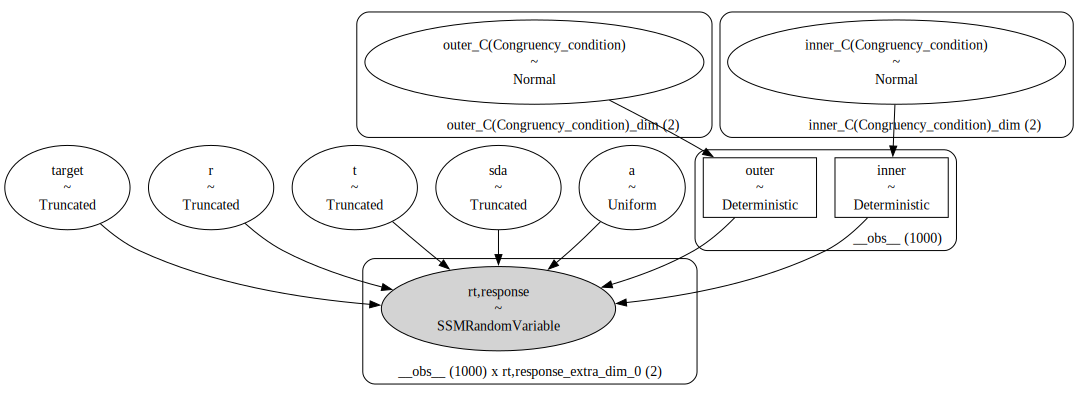

In [3]:
onnx_path = r"/users/azhan378/hssm_estimates/onnx modles /new_bounds_shrink_spot_lan_eab5ad7c5e7711efa296a0423f3e9b4e_torch_model.onnx"
ssm_model = hssm.HSSM(data=test_dataset_sim, 
                                model="shrink_spot",
                                model_config = {
                                    "list_params": ["a", "z", "t", "target", "outer", "inner", "r", "sda"],
                                    "bounds": { 
                                        "a": (0.3, 3.0), 
                                        "z": (0.1, 0.9),
                                        "t": (0.001, 2),
                                        "target": (2.0, 5.5), 
                                        "outer": (-5.5, 5.5), 
                                        "inner": (-5.5, 5.5), 
                                        "r": (0.01, 0.05), 
                                        "sda": (1, 3), 
                                    
                                        
                                    }, 
                                    "backend": "jax",   

                                }, 
                            
                                z=z_true_sim,
                                # sda=2,
                                # r=0.15,
                                #   target = 0.5, 
                                # inner = [-p_target_true_sim,p_target_true_sim], 
                                # outer = [-p_target_true_sim,p_target_true_sim],
                                #   target = 1, 
                                loglik= onnx_path,
                                loglik_kind="approx_differentiable", 
                                p_outlier = 0, 
                                include=[
            {
                "name": "r",
                "prior": {"name": "Uniform", "lower": 0.01, "upper": 0.05, 'initval': r_true_sim}

            },
            {
                "name": "t",
                "prior": {"name": "Uniform", "lower": 0.001, "upper": 2, 'initval': t_true_sim}

            },
            {
                "name": "sda", 
                "prior": {"name": "Uniform", "lower": 1, "upper": 3, 'initval': sda_true_sim}
            },

            {'name': 'target',
            'prior': {'name': 'Uniform', 'lower': 2, 'upper': 5.5, 'initval': p_target_true_sim}
            },
            {'name': 'outer', 
            'formula': 'outer ~ 0 + C(Congruency_condition)'}, 
            {'name': 'inner', 
            'formula': 'inner ~ 0 + C(Congruency_condition)'}, 

        
        ])
pm.model_to_graphviz(ssm_model.pymc_model)

In [4]:
infer_data_simple_ddm_model = ssm_model.sample(
    sampler="nuts_numpyro",  # type of sampler to choose, 'nuts_numpyro', 'nuts_blackjax' of default pymc nuts sampler
    cores=1,  # how many cores to use
    chains=4,  # how many chains to run
    draws=2000,  # number of draws from the markov chain
    tune=2500,  # number of burn-in samples
)

Compiling.. :   0%|          | 0/4500 [00:00<?, ?it/s]







Running chain 0:   5%|▌         | 225/4500 [12:59<4:05:53,  3.45s/it]


Running chain 0:  10%|█         | 450/4500 [14:21<1:50:13,  1.63s/it]


Running chain 0:  15%|█▌        | 675/4500 [15:42<1:07:02,  1.05s/it]


Running chain 0:  25%|██▌       | 1125/4500 [18:03<33:38,  1.67it/s] 


Running chain 0:  30%|███       | 1350/4500 [19:05<25:38,  2.05it/s]


Running chain 0:  35%|███▌      | 1575/4500 [20:01<19:59,  2.44it/s]


Running chain 0:  40%|████      | 1800/4500 [20:59<16:14,  2.77it/s]


Running chain 0:  45%|████▌     | 2025/4500 [21:57<13:33,  3.04it/s]


Running chain 0:  50%|█████     | 2250/4500 [22:52<11:21,  3.30it/s]


Running chain 0:  55%|█████▌    | 2475/4500 [23:55<09:58,  3.38it/s]




Running chain 0:  65%|██████▌   | 2925/4500 [26:22<08:10,  3.21it/s]


Running chain 0:  70%|███████   | 3150/4500 [27:33<07:01,  3.20it/s]


Running chain 0:  75%|███████▌  | 3375/4500 [28:43<05:50,  3.21it/s]


Running c

In [1]:
print("true_target", p_target_true_sim)
print("sda", sda_true_sim)
print("a", a_true_sim)
print('t', t_true_sim)


NameError: name 'p_target_true_sim' is not defined

In [ ]:
az.plot_trace(
    infer_data_simple_ddm_model
    # var_names="~log_likelihood",  # we exclude the log_likelihood traces here
)
plt.tight_layout()

                                    mean     sd  hdi_3%  hdi_97%  mcse_mean  \
a                                  1.183  0.018   1.149    1.215      0.000   
inner_C(Congruency_condition)[-1] -0.008  0.248  -0.462    0.454      0.004   
inner_C(Congruency_condition)[1]  -0.014  0.248  -0.497    0.432      0.004   
outer_C(Congruency_condition)[-1] -1.786  0.273  -2.346   -1.351      0.007   
outer_C(Congruency_condition)[1]  -1.838  0.272  -2.395   -1.398      0.007   
r                                  0.015  0.004   0.010    0.022      0.000   
sda                                2.819  0.147   2.544    3.000      0.003   
t                                  1.006  0.003   1.001    1.011      0.000   
target                             3.005  0.829   2.000    4.627      0.019   

                                   mcse_sd  ess_bulk  ess_tail  r_hat  
a                                    0.000    4766.0    3851.0    1.0  
inner_C(Congruency_condition)[-1]    0.003    4353.0    3324.0   

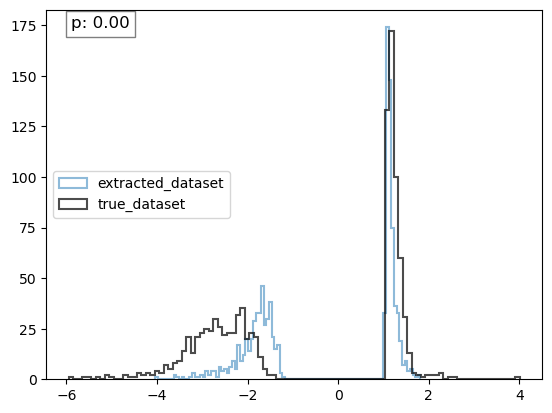

In [18]:
from scipy.stats import ks_2samp 

df = az.summary(infer_data_simple_ddm_model)
print(df)
compare_data_set = hssm.simulate_data(model='shrink_spot',
                            theta=dict(
                                        a = df.loc["a", 'mean'],
                                        z = z_true_sim,
                                        t = df.loc["t", 'mean'],
                                        p_target = df.loc['target', 'mean'],
                                        # p_target = 0.5,
                                        p_outer = [-df.loc['target','mean'],df.loc['target','mean']],
                                        p_inner = [-df.loc['target','mean'],df.loc['target','mean']],
                                       
                                        r = df.loc['r', 'mean'], 
                                        sda = df.loc['sda', 'mean'],
                                        
                                        ),
                                        size = 500)

plt.hist(compare_data_set['rt'] * compare_data_set['response'], bins=100, histtype = "step", alpha=0.5, label="extracted_dataset", linewidth=1.5) 
plt.hist(test_dataset_sim['rt'] * test_dataset_sim['response'], bins=100, histtype = "step", alpha=0.7, label="true_dataset", color='black', linewidth=1.5)
statistic, p_value = ks_2samp(compare_data_set['rt'] * compare_data_set['response'], test_dataset_sim['rt'] * test_dataset_sim['response'])
plt.annotate(f'p: {p_value:.2f}',
xy=(0.05, 0.95), 
xycoords='axes fraction', 
fontsize=12,
backgroundcolor='white',
bbox=dict(facecolor='white', alpha=0.5))
plt.legend()

array([[<Axes: ylabel='inner_C(Congruency_condition)\n-1'>, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='inner_C(Congruency_condition)\n1'>, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='outer_C(Congruency_condition)\n-1'>, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='outer_C(Congruency_condition)\n1'>, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='r'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sda'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='t'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='a', ylabel='target'>,
        <Axes: xlabel='inner_C(Congruency_condition)\n-1'>,
        <Axes: xla

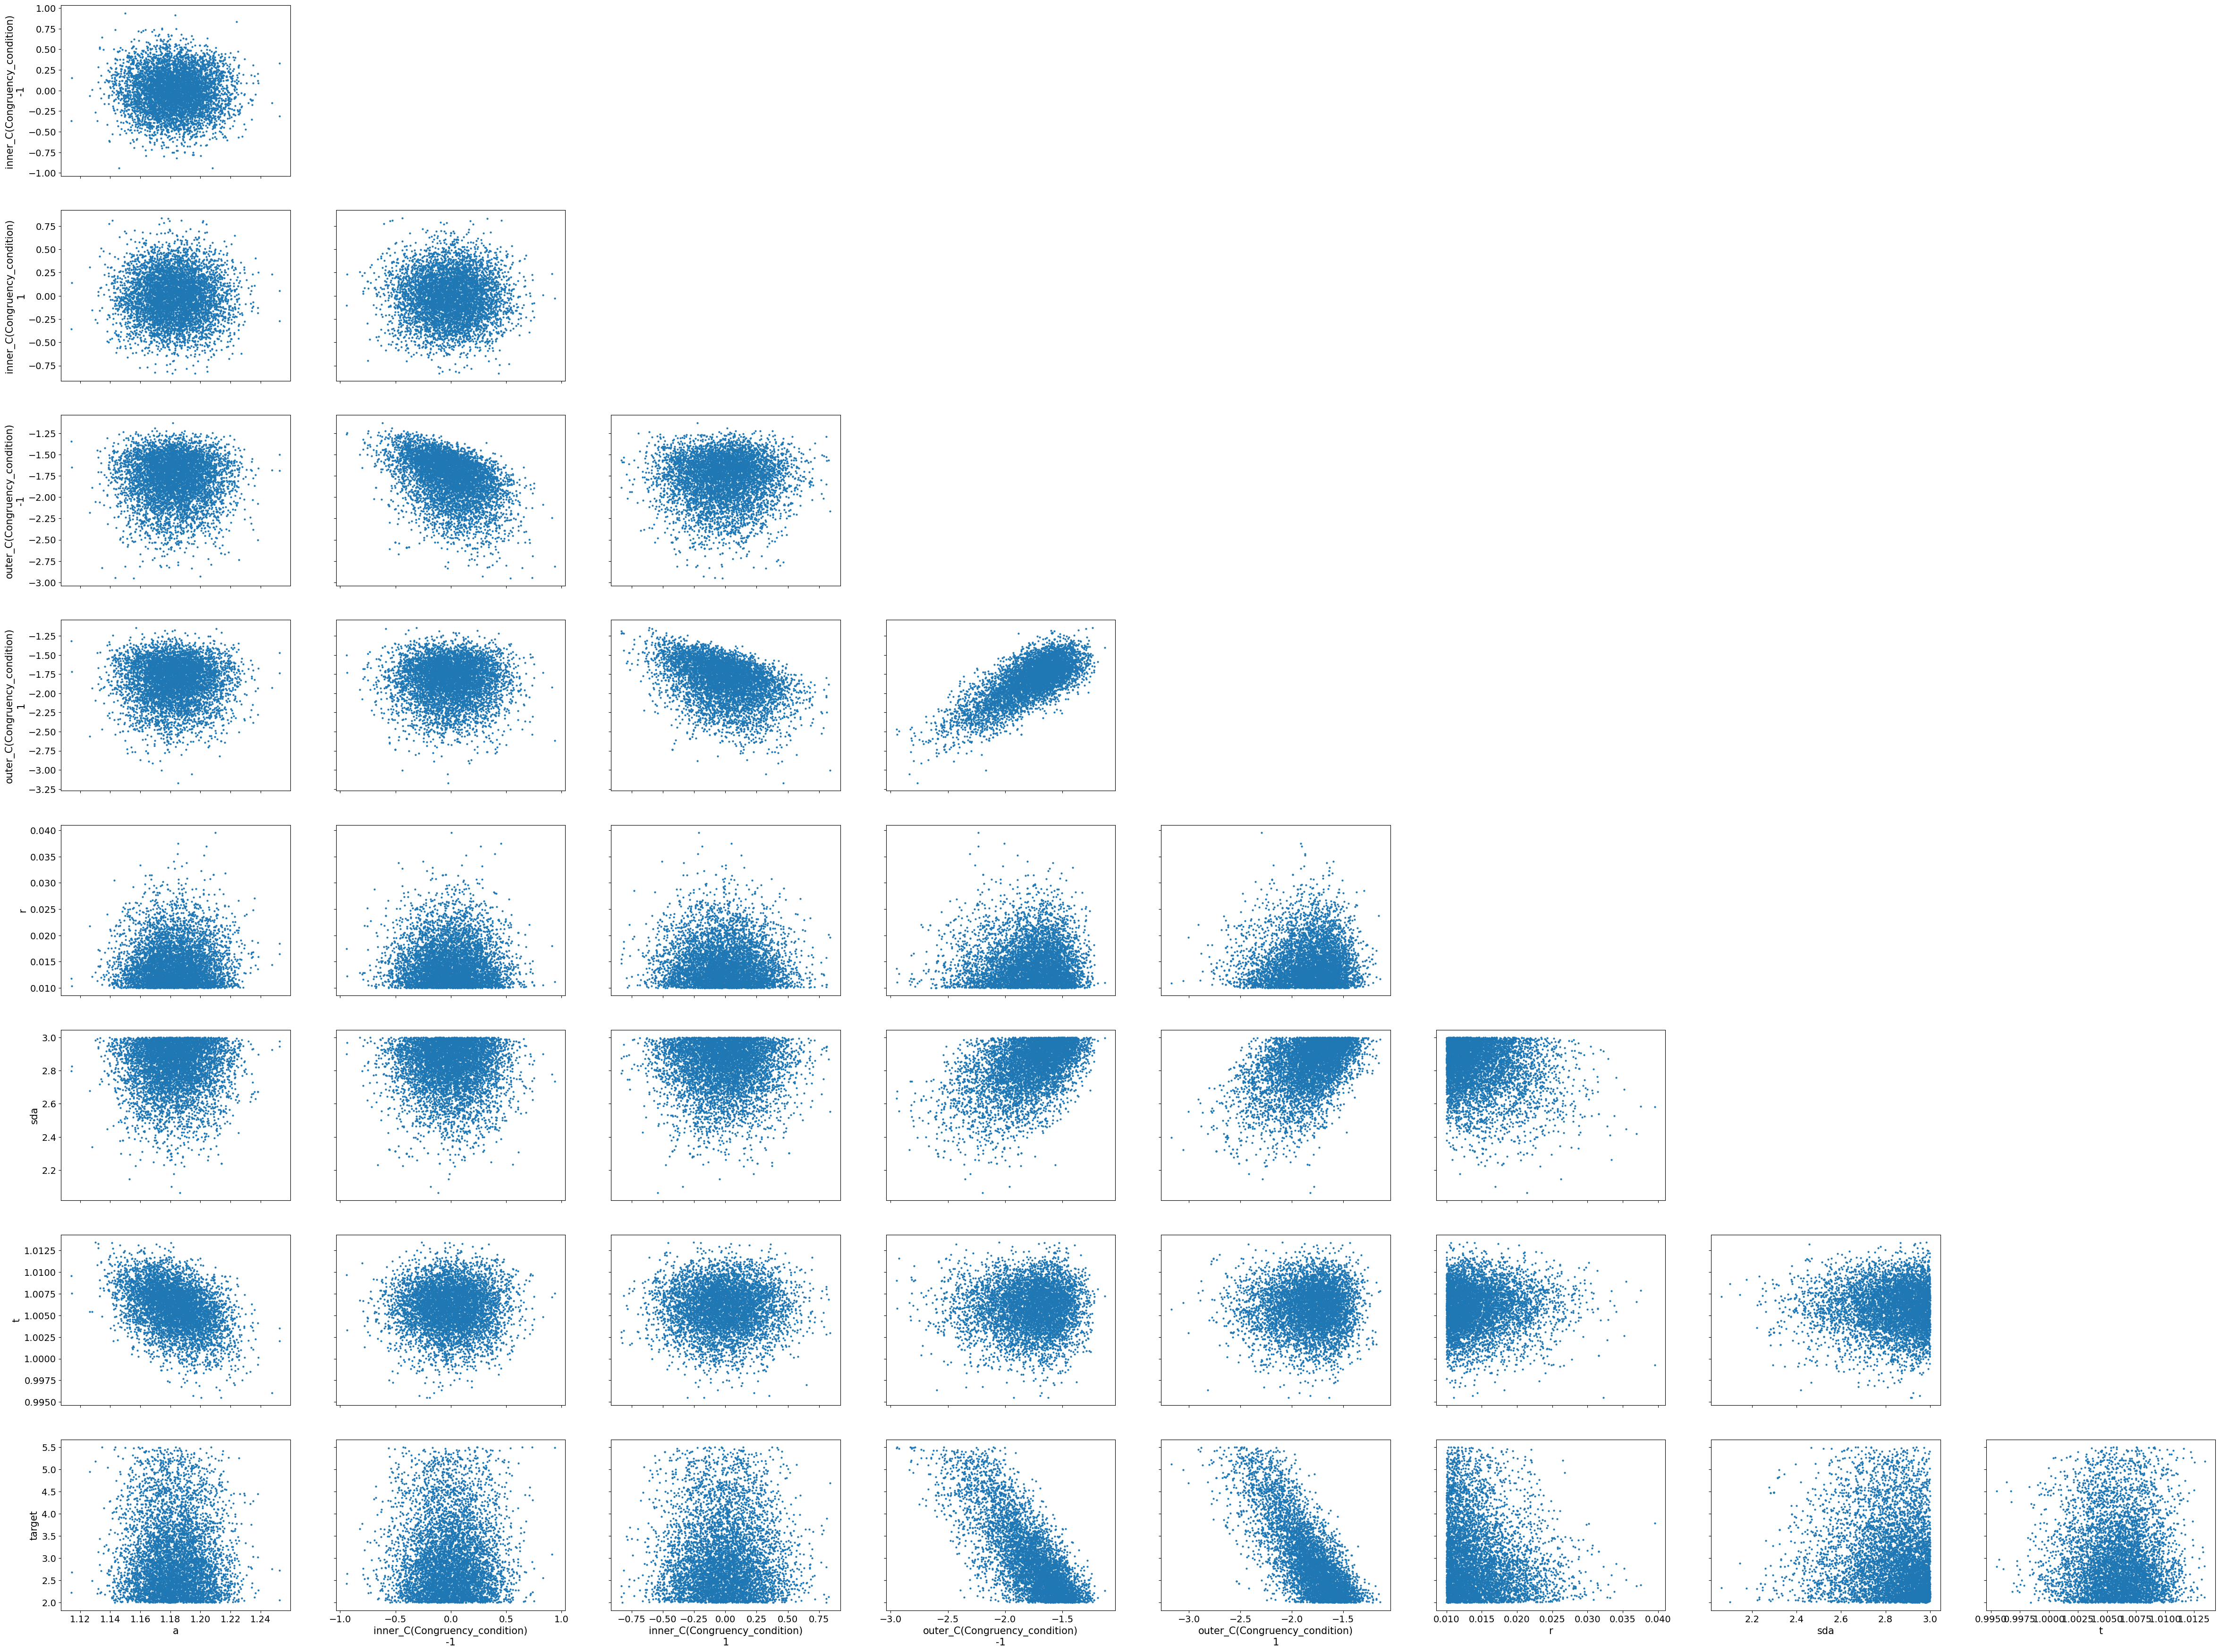

In [8]:
az.plot_pair(ssm_model.traces)

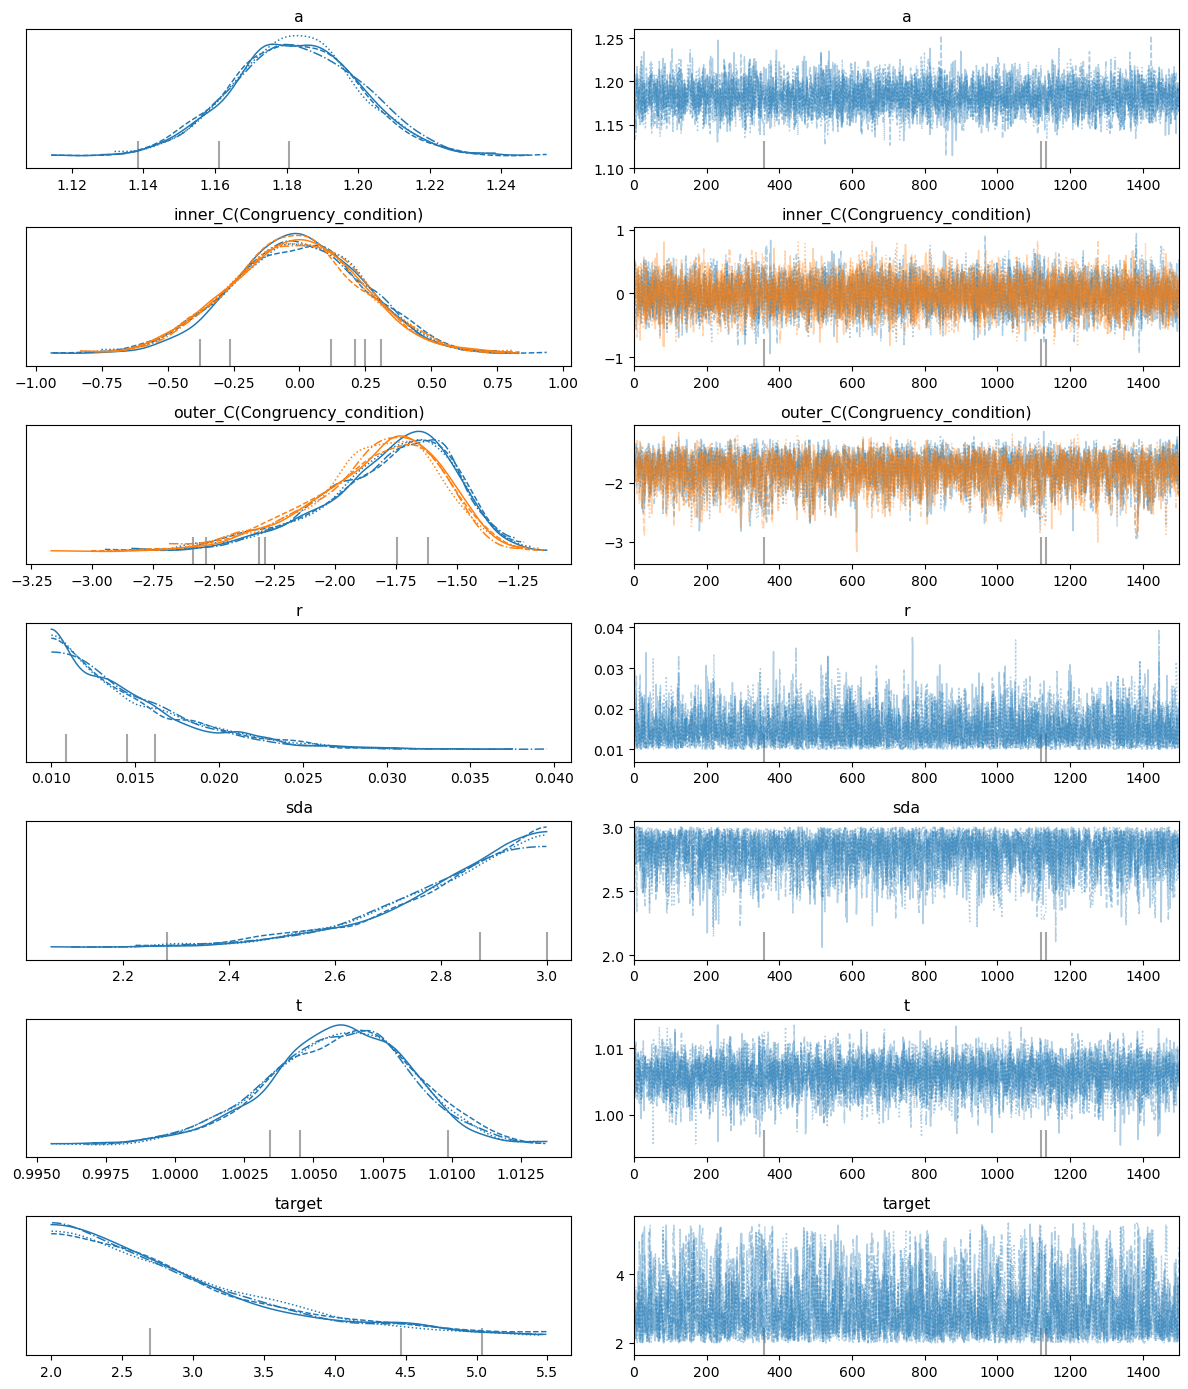

In [11]:
az.plot_trace(infer_data_simple_ddm_model)
plt.tight_layout()